<h1><center>Laboratorio 10: Interpretabilidad 🤖</center></h1>

<center><strong>MDS7202: Laboratorio de Programación Científica para Ciencia de Datos</strong></center>

### Cuerpo Docente:

- Profesor: Ignacio Meza, Gabriel Iturra
- Auxiliar: Sebastián Tinoco
- Ayudante: Arturo Lazcano, Angelo Muñoz

### Equipo: SUPER IMPORTANTE - notebooks sin nombre no serán revisados

- Nombre de alumno 1: Nicolás Becerra
- Nombre de alumno 2: Simón Sanfeliú


### **Link de repositorio de GitHub:** https://github.com/SimonSanfeliu/MDS7202-BS/tree/L10

### Indice 

1. [Temas a tratar](#Temas-a-tratar:)
3. [Descripcción del laboratorio](#Descripción-del-laboratorio.)
4. [Desarrollo](#Desarrollo)

## Temas a tratar

- Clasificación usando `XGBoost`.
- Métodos Agnósticos Globales de Interpretabilidad (`Partial Dependence Plot`, `Permutation Feature Importance`)
- Métodos Agnósticos Locales de Interpretabilidad (`Scoped Rules`, `SHAP`)

## Reglas:

- **Grupos de 2 personas**
- Asistencia **obligatoria** a instrucciones del lab (viernes 16.15). Luego, pueden quedarse trabajando en las salas o irse.
- **No se revisarán entregas de personas ausentes**. 
- Cualquier duda fuera del horario de clases al foro. Mensajes al equipo docente serán respondidos por este medio.
- Prohibidas las copias. 
- Pueden usar cualquer matrial del curso que estimen conveniente.

### Objetivos principales del laboratorio

- Generar un pipeline de clasificación con `XGBoost`.
- Implementar modelos de interpretabilidad para explicar el funcionamiento del modelo de clasificación.

El laboratorio deberá ser desarrollado sin el uso indiscriminado de iteradores nativos de python (aka "for", "while"). La idea es que aprendan a exprimir al máximo las funciones optimizadas que nos entrega `pandas`, las cuales vale mencionar, son bastante más eficientes que los iteradores nativos sobre DataFrames.

## 1. Problemas Clínicos del Dr. Simi

<p align="center">
  <img src="https://gantz.cl/wp-content/uploads/2020/01/79024136_2718114448239059_7240913062570491904_o.jpg" width="350">
</p>

El reconocido **Dr. Simi**, famoso vendedor de medicamentos en latinoamerica, debido a la creciente prevalencia de enfermedades crónicas, como la diabetes, decidió abrir una clínica especializada en el tratamiento de esta enfermedad en nuestro país.

La clínica del Doctor Simi se convirtió en un lugar donde los pacientes con diabetes podrían recibir atención médica integral. El personal médico estaba compuesto por especialistas en endocrinología, nutrición y enfermería, todos capacitados en el manejo de la diabetes.

Sin embargo él se ha dado cuenta que los tiempos han cambiado y gracias a las tecnologías es posible generar mejores predicciones en la diabetes conociendo el historial médico de las personas. Por esto, el doctor se ha colocado una meta de incluir modelos de machine learning dentro de sus clínicas, para ello le ha solicitado crear un modelo capaz de predecir/clasificar diabetes pero le rogó que el desarrollo del modelo tuviera un especial enfoque en la interpretabilidad de lo que hace su modelo.

Para que usted pueda entrenar el modelo, Dr. Simi le ha entregado un dataset de todos los clientes que fueron detectados con diabetes a lo largo de la historia de la clinica. Con ello, adjunta el historial médico de las personas en forma de datos tabulares para que usted pueda realizar fácilmente la clasificación.


In [1]:
import numpy as np
import pandas as pd

df = pd.read_csv('diabetes_data.csv')
df.head(4)

,Age,Sex,HighChol,CholCheck,BMI,Smoker,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,GenHlth,MentHlth,PhysHlth,DiffWalk,Stroke,HighBP,Diabetes
0,4.0,1.0,0.0,1.0,26.0,0.0,0.0,1.0,0.0,1.0,0.0,3.0,5.0,30.0,0.0,0.0,1.0,0.0
1,12.0,1.0,1.0,1.0,26.0,1.0,0.0,0.0,1.0,0.0,0.0,3.0,0.0,0.0,0.0,1.0,1.0,0.0
2,13.0,1.0,0.0,1.0,26.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,10.0,0.0,0.0,0.0,0.0
3,11.0,1.0,1.0,1.0,28.0,1.0,0.0,1.0,1.0,1.0,0.0,3.0,0.0,3.0,0.0,0.0,1.0,0.0


## 2. Clasificación de pacientes con diabetes (0.5 puntos)

<p align="center">
  <img src="https://media.tenor.com/QH--g3ZaSbsAAAAC/dr-simi-abrazo.gif" width="400">
</p>

En primer lugar, el reconocido doctor le pide entrenar un modelo de `XGBoost` utilizando como target la columna `Diabetes` del dataset `diabetes_data.csv`. Para el entrenamiento tome en cuenta **todos** los pasos necesarios para entrenar un modelo de aprendizaje supervisado vistos hasta la fecha (use `Pipeline`, `ColumnTransformer`, etc.), comente sus decisiones y los resultados obtenidos con el modelo. ¿Es acaso un buen predictor de diabetes?, ¿Qué buscan explicar las métricas utilizadas?, ¿las métricas utilizadas para medir la predictibilidad le permiten asegurar que su modelo haga una buena elección de las features?. 

In [2]:
!pip install xgboost

Defaulting to user installation because normal site-packages is not writeable


In [3]:
# Función para transformación logarítmica
def to_log(df_s):
    """
    Aplica una transformación logarítimica a una serie de datos.

    Parameters
    ----------
    df_s : pd.Series
        Serie de datos a transformar.

    Returns
    -------
    pd.Series
        Serie de datos transformada. 
    """
    # Revisando datos
    assert type(df_s) == pd.DataFrame

    # Transformando los datos de la serie a escala logarítmica
    df_s = df_s.apply(lambda x: np.log(x + 1))
    return df_s

In [26]:
# Obteniendo librerías necesarias
from sklearn.model_selection import train_test_split 
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer, MinMaxScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix

import matplotlib.pyplot as plt
import itertools

# Definiendo la semilla
RANDOM_STATE = 42

# Separando el conjunto de datos
X_train, X_rest, y_train, y_rest = train_test_split(df, df["Diabetes"], test_size=.3, random_state=RANDOM_STATE)
X_val, X_test, y_val, y_test = train_test_split(X_rest, y_rest, test_size=.33, random_state=RANDOM_STATE)
X_train.drop(columns=["Diabetes"], inplace=True)
X_val.drop(columns=["Diabetes"], inplace=True)
X_test.drop(columns=["Diabetes"], inplace=True)

# Separando los datos en numéricos y categóricos
num_cols = X_train.corr(numeric_only=True).columns.to_list()
cat_cols = [col for col in X_train.columns if not col in num_cols]

# Atributos numéricos
num_pipe = Pipeline([
                ('Logaritmic scaler', FunctionTransformer(to_log, feature_names_out='one-to-one')),
                ('MinMax scaler', MinMaxScaler())
            ])
# Atributos categóricos
cat_pipe = Pipeline([
    ('Encoder', OneHotEncoder(sparse_output=False))
])

# Creando ColumnTransformer
ctrans = ColumnTransformer(
        transformers=[
            ("Categorico", cat_pipe, cat_cols),
            ("Numerico", num_pipe, num_cols),
        ],
        remainder="passthrough",
        verbose_feature_names_out=False
)
ctrans.set_output(transform='pandas')

ColumnTransformer(remainder='passthrough',
                  transformers=[('Categorico',
                                 Pipeline(steps=[('Encoder',
                                                  OneHotEncoder(sparse_output=False))]),
                                 []),
                                ('Numerico',
                                 Pipeline(steps=[('Logaritmic scaler',
                                                  FunctionTransformer(feature_names_out='one-to-one',
                                                                      func=<function to_log at 0x0000020D915AE320>)),
                                                 ('MinMax scaler',
                                                  MinMaxScaler())]),
                                 ['Age', 'Sex', 'HighChol', 'CholCheck', 'BMI',
                                  'Smoker', 'HeartDiseaseorAttack',
                                  'PhysActivity', 'Fruits', 'Veggies',
                                  'HvyAlcoholConsump', 'GenHlth', 'MentHlth',
                                  'PhysHlth', 'DiffWalk', 'Stroke',
                                  'HighBP'])],
                  verbose_feature_names_out=False)

              precision    recall  f1-score   support

           0       0.71      0.77      0.74      6568
           1       0.79      0.73      0.76      7641

    accuracy                           0.75     14209
   macro avg       0.75      0.75      0.75     14209
weighted avg       0.75      0.75      0.75     14209



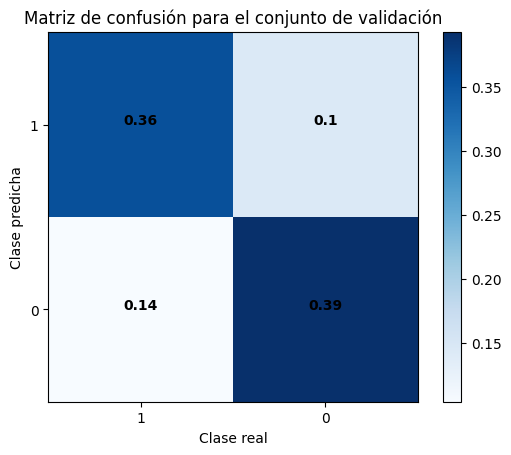

In [29]:
import xgboost as xgb

# Pipeline de entrenamiento
pipe_train = Pipeline([
    ("Scaling", ctrans),
    ("Classifier", xgb.XGBClassifier(objective='binary:logistic'))
])

# Entrenando
model = pipe_train.fit(X_train, y_train)

# Prediciendo en validación
y_pred_val = model.predict(X_val)

# Reporte de clasificación y matriz de confusión
print(classification_report(y_pred_val, y_val))
conf_mat = confusion_matrix(y_val, y_pred_val, normalize='all')
plt.imshow(conf_mat, cmap=plt.cm.Blues)
plt.xticks([1,0], [0,1])
plt.yticks([1,0], [0,1])
plt.title("Matriz de confusión para el conjunto de validación")
plt.xlabel("Clase real")
plt.ylabel("Clase predicha")
plt.colorbar()
for i,j in itertools.product(range(conf_mat.shape[0]), range(conf_mat.shape[1])):
    plt.text(i,j,round(conf_mat[i,j], 2), horizontalalignment="center", color="black", weight="bold")

              precision    recall  f1-score   support

           0       0.71      0.77      0.74      3173
           1       0.79      0.74      0.76      3826

    accuracy                           0.75      6999
   macro avg       0.75      0.75      0.75      6999
weighted avg       0.76      0.75      0.75      6999



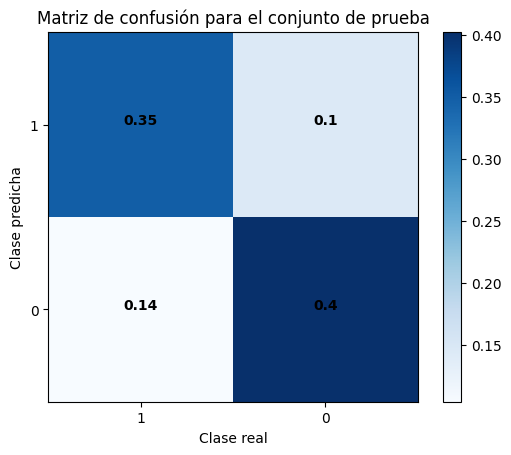

In [30]:
# Prediciendo en prueba
y_pred_test = model.predict(X_test)

# Reporte de clasificación y matriz de confusión
print(classification_report(y_pred_test, y_test))
conf_mat2 = confusion_matrix(y_test, y_pred_test, normalize='all')
plt.imshow(conf_mat2, cmap=plt.cm.Blues)
plt.xticks([1,0], [0,1])
plt.yticks([1,0], [0,1])
plt.title("Matriz de confusión para el conjunto de prueba")
plt.xlabel("Clase real")
plt.ylabel("Clase predicha")
plt.colorbar()
for i,j in itertools.product(range(conf_mat2.shape[0]), range(conf_mat2.shape[1])):
    plt.text(i,j,round(conf_mat2[i,j], 2), horizontalalignment="center", color="black", weight="bold")

> Para el pipeline mostrado aquí, se decidió tomar un clasificador XGBoost para poder hacer de forma correcta la clasificación binaria pedida, especificando este tipo de clasificación en sus parámetros. Se decidió seguir el mismo pipeline del laboratorio anterior, teniendo un OneHotEncoder para las variables no numéricas y aplicando una transformación logarítmica junto con un MixMaxScaler para las numéricas, debido a la eficacia de éste y de los buenos resultados que ha entregado en laboratorios anteriores. Sin embargo, dada la gran cantidad de columnas numéricas con valores pequeños, podría ser innecesario un preprocesamiento de estos datos tan exhaustivo, pero por convención y eficiencia se deja de todos modos.

> Respecto a los resultados obtenidos, se decidió probar tanto en validación como en prueba, además de haber probado distintas configuraciones de parámetros en el clasificador. Finalmente se prefirió dejar los valores por defecto y se pudo ver que en ambos conjuntos se obtuvo un accuracy en el F1 Score de 0.75. Esto implicaría que el clasificador es es apropiado para predecir la diabetes en los pacientes, pero que puede mejorar su rendimiento.

> La *precision* muestra cuántas predicciones correctas se hicieron de una clase dividido en cuántas predicciones de esa clase se hicieron. Mientras más alto el valor, mejor, teniendo que en ambos conjuntos se tienen precisiones de 0.71 para la clase 0 (no diabetes) y 0.79 para la clase 1 (diabetes). Esto daría cuenta de que se predice mejor el que se tenga diabetes a predecir que no lo tiene (hay muchos falsos positivos en el caso de no tener diabetes).

> El *recall* es cuántas predicciones correctas se hicieron de una clase dividido en cuántos valores reales de ésta hay en el dataset. Mientras más alto, mejor, teniendo que en ambos conjuntos el recall fue 0.77 para la clase 0 y 0.74 para la clase 1. Esto quiere decir que, mientras que dentro de sus propias predicciones, la clase 1 es mejor predicha, en el set de datos global, se predice mejor la clase 0 (hay más falsos negativos de la clase 0).

> Finalmente, el F1 Score combina las dos métricas anteriores, teniendo en consideración ambos *trade-offs*. De esta forma, es una métrica muy global para definir la eficiencia de los modelos, de ahí que se vea que la clase 1 tiene en ambos conjuntos un valor de 0.76 y la 0 de 0.74, indicando una mayor eficiencia del modelo a la hora de predecir que una persona tiene efectivamente diabetes; puesto que mientras más ceracana al 1 esta métrica, mejor será el modelo.

> Tomando esto en consideración es que se usa el F1 Score para medir el rendimiento, notando que el *accuracy* total de los conjuntos en el F1 Score es de 0.75, lo que indica un gran rendimiento, pero que aún puede mejorarse, ya que usualmente un modelo con *accuracy* (de todas las predicciones, cuántas fueron correctas) sobre 0.7 es decente, pero no perfecto. Asimismo, las otras métricas brindadas permiten dar cuenta de los buenos resultados que da el modelo, teniendo a todas sobre 0.7 y cercanas al 1(la perfección), denotando la eficiencia de éste y pudiendo entrever su eficiencia por clase.

## 3. Importancia de las features con XGBoost (0.5 puntos)

<p align="center">
  <img src="https://media.tenor.com/5JAj5_IiagEAAAAd/dr-simi-dr-simi-dance.gif" width="400">
</p>

Para añadir el toque de interpretabilidad que Dr. Simi le pide, se le pide calcular la **importancia de las features** del modelo entrenado utilizando todos los métodos (*weight*, *cover*, *gain*) que posee xgboost usando `plot_importance`. ¿Los resultados obtenidos con los diferentes métodos son compatibles?, comente sus resultados y a que se debe la igualdad o desigualdad que ve en los resultados. Finalmente, ¿las importancias obtenidas son suficientes para obtener la interpretabilidad de un modelo que utiliza árboles? ¿Qué debilidad presenta este método?

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

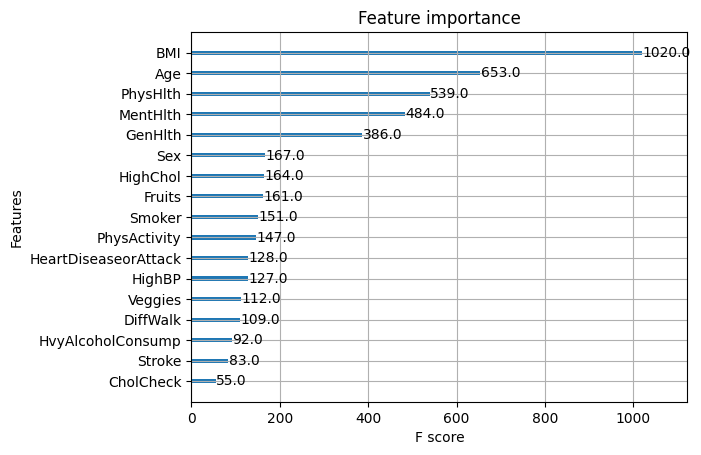

In [33]:
# Obteniendo el gráfico de importancia de los features para distintos tipos de cálculo de importancia
from xgboost import plot_importance
# Método weight
plot_importance(model["Classifier"], importance_type="weight")

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

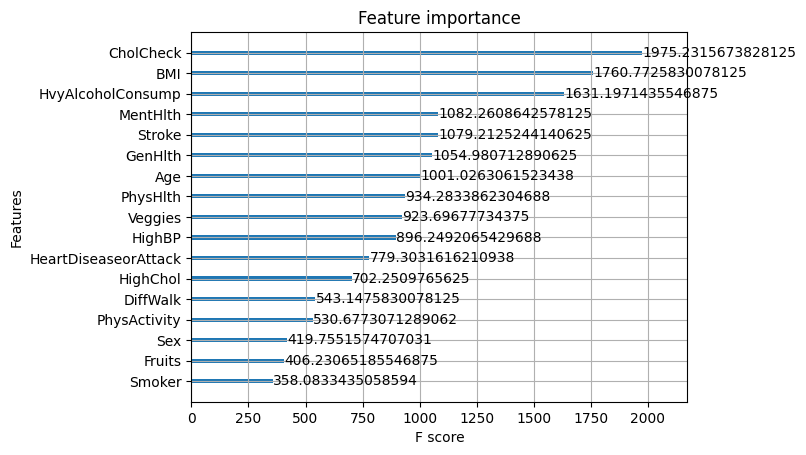

In [34]:
# Método cover
plot_importance(model["Classifier"], importance_type="cover")

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

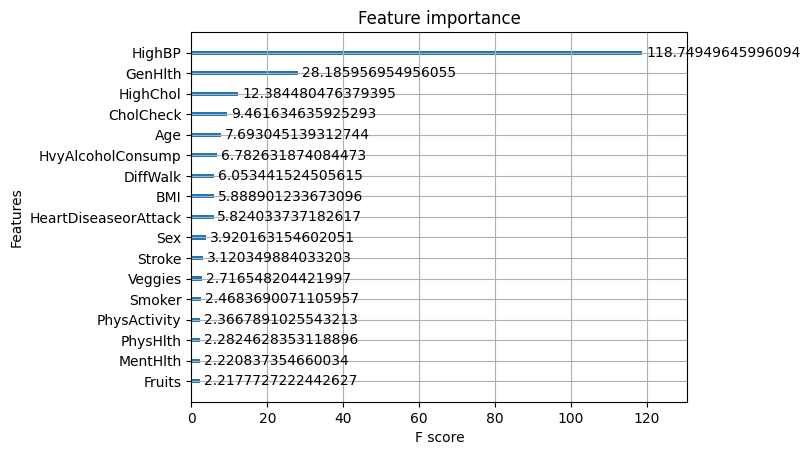

In [35]:
# Método gain
plot_importance(model["Classifier"], importance_type="gain")

## 4. Métodos Agnósticos Globales (1.0 puntos)

<p align="center">
  <img src="https://media.tenor.com/JcRHtjVuXN8AAAAC/dr-simi-farmacias-similares.gif" width="400">
</p>

Para mitigar los problemas encontrados en la sección anterior, Dr. Simi le pide implementar un **método de permutación** que le permita observar la importancia de las features. Visualice los resultados de este método en un gráfico. Para que su modelo sea consistente, repita el proceso **30 veces** y verifique la desviación estándar de sus resultados (¿Qué señala está?). Además, responda las siguientes preguntas:


- ¿Cómo mide la importancia de las features su propuesta?
- ¿Qué features tienen un mayor impacto en la salida del modelo?. Comente las 5 primeras, ¿Tienen sentido?
- ¿Cómo cambian sus conclusiones con respecto a las features importances del punto anterior?
- Nombre y explique 3 ventajas y 3 desventajas del método implementado.

In [ ]:
# Inserte su código aquí

## 5. Métodos Agnósticos Locales (2.0 puntos)

<p align="center">
  <img src="https://i.makeagif.com/media/1-27-2017/fBrzT8.mp4" width="400">
</p>

### 5.1 Calculando Shap Values (0.4 puntos)

Alegre por saber cómo funciona el modelo de predicción a nivel general, Dr. Simi le pide ahora interpretar las predicciones de su modelo a nivel de paciente (es decir, desde un punto de vista **local**). Para esto, el ilustre farmacéutico le pide calcular los *shap values* de su modelo. ¿Qué representa cada número en su resultado? ¿Es posible atribuir un significado a la positividad/negatividad de cada valor?

In [1]:
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.6/572.6 kB 62.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 85.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.1/42.1 MB 38.1 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip


In [10]:
import warnings
warnings.filterwarnings("ignore", message=".*The 'nopython' keyword.*")

In [3]:
# Inserte código para calcular shapley values aquí

### 5.2 Aporte local (0.4 puntos)

Usando los *shap values* calculados, grafique el **aporte** de las diferentes variables para las instancias **1**, **9** y **150**, interprete sus resultados y responda:
- ¿Qué variables afectan de manera positiva/negativa a la probabilidad de poseer diabetes? 
- ¿Existe algún patrón común entre las instancias analizadas? 
- ¿Es posible generalizar estas conclusiones a todo el dataset?

In [4]:
# Inserte código para generar gráficos de aporte local aquí

### 5.3 Aporte global (0.4 puntos)

Genere ahora una visualización donde se grafique el aporte de cada feature a nivel **global** e interprete sus resultados. ¿Qué diferencias existen con las conclusiones generadas a nivel de instancia?

In [5]:
# Inserte código para generar gráficos de aporte global aquí

### 5.4 Scatter plot (0.4 puntos)

Grafique ahora un *scatterplot* entre los *shap values* y las primeras 5 features con mayor impacto global (un gráfico por cada feature), coloreando cada punto por la probabilidad de tener diabetes. ¿Qué puede concluir de sus resultados?

In [6]:
# Inserte código para generar gráficos de feature vs shap value aquí

### 5.5 Partial Dependence Plot (0.4 puntos)

Finalmente, se le pide generar un gráfico del tipo **Partial Dependence Plot** para las mismas 5 variables con mayor impacto global usando una submuestra de **1000 observaciones**. ¿Qué relación existe entre la salida promedio del modelo y cada feature analizada? ¿Son estas conclusiones generalizables para todo el conjunto de datos?

In [7]:
# Inserte código para generar gráficos PDP aquí

## 6. Sistema de Reglas! (1.0 puntos)

<p align="center">
  <img src="https://media.baamboozle.com/uploads/images/125978/1638281150_1380186_gif-url.gif" width="400">
</p>

Después de todo el trabajo hecho, Dr. Simi le pide simplificar el funcionamiento de su modelo en un sistema de reglas que le permita explicar a sus clientes las predicciones que genera su modelo. En particular, Dr. Simi le pide explicar la decisión tomada para las observaciones **1000**, **3001** y **5751**. Con las reglas propuestas señale a **cuánta población** es posible explicar con estas reglas e indique la **precisión** que poseen las reglas en la totalidad de los datos. ¿Tienen sentido sus reglas propuestas para las observaciones?. Fundamente sus respuesta señalando el impacto que tienen sus reglas sobre todo el conjunto de datos.

In [26]:
!pip install alibi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 524.2/524.2 kB 29.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.2/13.2 MB 67.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 85.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 313.2/313.2 kB 50.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 219.4/219.4 kB 33.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 84.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 91.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.5/98.5 MB 19.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 81.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 682.2/682.2 kB 65.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 82.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 42.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [27]:
from alibi.explainers import AnchorTabular

2023-06-16 03:21:35.062920: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-16 03:21:35.266905: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-06-16 03:21:35.266966: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-06-16 03:21:35.308521: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-06-16 03:21:38.061257: W tensorflow/stream_executor/platform/de

In [8]:
# Inserte su código para generar sistema de reglas aquí

idx = 1000
# explicar predicción idx 1000

idx = 3001
# explicar predicción idx 3001

idx = 5751
# explicar predicción idx 5751

# Retrospectiva... (1.0 puntos)

En base a los diferentes métodos que implementa y ha comentado en este laboratorio, comente qué métodos le permiten entregar mejores conclusiones para la tarea de clasificación de diabetes. Por otro lado, ¿qué métodos son más útiles para el problema del doctor Simi, métodos agnosticos locales o globales?

> Fundamente su Respuesta aquí

# Conclusión
Eso ha sido todo para el lab de hoy, recuerden que el laboratorio tiene un plazo de entrega de una semana. Cualquier duda del laboratorio, no duden en contactarnos por mail o U-cursos.

![Gracias Totales!](https://media.tenor.com/ctnq4bhZE3gAAAAC/drsimi-simi.gif)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=87110296-876e-426f-b91d-aaf681223468' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>